In [1]:
import re, time
from tqdm import tqdm_notebook

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time, ast
from pathlib import Path

pj_dir = Path(os.getcwd()).parents[0]
data_dir = pj_dir/'data'
img_dir = pj_dir/'images'
src_dir = pj_dir/'src'
sys.path.append(str(src_dir))

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd

from tqdm import tqdm_notebook
from dotenv import load_dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import japanize_matplotlib

In [11]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
import logging
logging.basicConfig(level=logging.INFO)

In [13]:
df = pd.read_csv(data_dir/'rebuildfm.csv')

In [14]:
df.head()

,date,persons,record_time,shownotes,title
0,Feb 13-2013,"['naoya', 'miyagawa']",52:53,"['5by5,', 'Mule Radio', 'Instapaper for Androi...","1: Podcasting, LTSV, RubyMotion (伊藤直也)"
1,Feb 20-2013,"['kenn', 'miyagawa']",47:56,"['Macbook Pro, Air update', 'Crashplan', 'Arq'...","2: Rails, Redis, VPS (Kenn Ejima)"
2,Feb 27-2013,"['frsyuki', 'kiyoto', 'miyagawa']",40:39,[],"3: MessagePack (frsyuki, kiyoto)"
3,Mar 06-2013,"['satoru', 'miyagawa']",31:04,[],"4: bkノート, Yak Shaving, Code Reviews (高林哲)"
4,Mar 13-2013,"['matz', 'miyagawa']",35:12,"['Ruby 20周年', 'Ruby 2.0.0-p0 released', 'COOKP...",5: Ruby 2.0 (まつもとゆきひろ)


In [150]:
def plot_hist(s, title, bins=30):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 1, 1)

    mean =s.mean().round(2)
    median = s.median().round(2)
    std = s.std().round(2)

    sns.distplot(s, ax=ax, bins=bins, kde_kws={"color": "k", "lw": 3})
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 20)
    vals = ax.get_yticks()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    ax.text( 0.99, 0.99, f"平均値: {mean:.2f} \n 中央値: {median:.2f} \n 標準偏差: {std:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=20)

In [16]:
df['date'] = pd.to_datetime(df['date'])
df['persons'] = df['persons'].apply(ast.literal_eval)
df['shownotes'] = df['shownotes'].apply(ast.literal_eval)

In [18]:
n_shownotes = []
for i, row in df.iterrows():
    n_s = len(row['shownotes'])
    n_shownotes.append(n_s)
df['n_shownotes'] = n_shownotes

In [41]:
hours = df['record_time'].str.extract('(?<=^)(\d)(?=:\d\d:\d\d$)').fillna(0).astype(int)
minutes = df['record_time'].str.extract('(\d\d)(?=:)') .fillna(0).astype(int)
seconds = df['record_time'].str.extract('(?<=\d\d)(\d\d)(?=$)') .fillna(0).astype(int)
df['minutes'] = hours*60 + minutes + seconds/60

In [23]:
df['is_aftershow'] = False
df['is_aftershow'] = df['is_aftershow'].mask(df['title'].str.contains('Aftershow', na=False), True)

In [24]:
df['is_aftershow'].value_counts()

False    221
True     123
Name: is_aftershow, dtype: int64

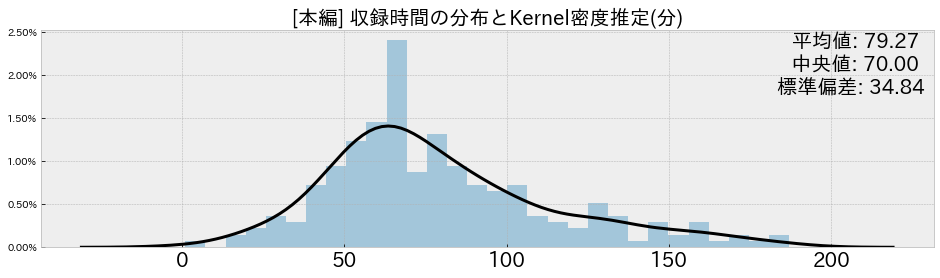

In [151]:
plot_hist(df.query('~is_aftershow')['minutes'], '[本編] 収録時間の分布とKernel密度推定(分)')

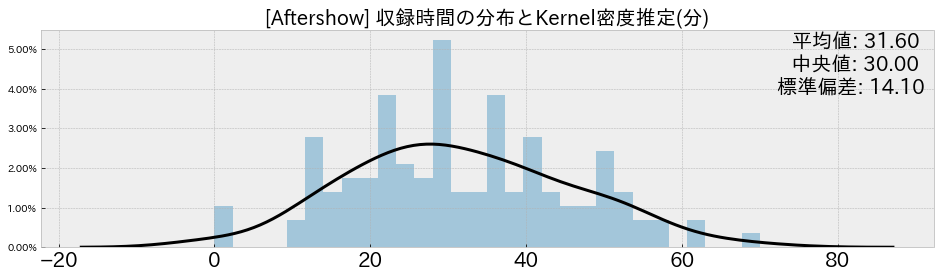

In [152]:
plot_hist(df.query('is_aftershow')['minutes'], '[Aftershow] 収録時間の分布とKernel密度推定(分)')

In [89]:
df.head()

,date,persons,record_time,shownotes,title,n_shownotes,minutes,is_aftershow,show_no
0,2013-02-13,"[naoya, miyagawa]",52:53,"[5by5,, Mule Radio, Instapaper for Android, LT...","1: Podcasting, LTSV, RubyMotion (伊藤直也)",15,52,False,1
1,2013-02-20,"[kenn, miyagawa]",47:56,"[Macbook Pro, Air update, Crashplan, Arq, Boxe...","2: Rails, Redis, VPS (Kenn Ejima)",14,47,False,2
2,2013-02-27,"[frsyuki, kiyoto, miyagawa]",40:39,[],"3: MessagePack (frsyuki, kiyoto)",0,40,False,3
3,2013-03-06,"[satoru, miyagawa]",31:04,[],"4: bkノート, Yak Shaving, Code Reviews (高林哲)",0,31,False,4
4,2013-03-13,"[matz, miyagawa]",35:12,"[Ruby 20周年, Ruby 2.0.0-p0 released, COOKPAD mi...",5: Ruby 2.0 (まつもとゆきひろ),7,35,False,5


In [87]:
df['show_no'] = df['title'].str.extract('^(\d\d?\d?)')
df['show_no'] = df['show_no'].mask(df['show_no'].isnull(), df['title'].str.extract('^Aftershow (\d\d?\d?)')[0])

In [107]:
dfm = pd.merge(df.query('~is_aftershow'), df.query('is_aftershow'), how='left', on='show_no', suffixes=('_main', '_after'))

In [111]:
dfm.head()

,date_main,persons_main,record_time_main,shownotes_main,title_main,n_shownotes_main,minutes_main,is_aftershow_main,show_no,date_after,persons_after,record_time_after,shownotes_after,title_after,n_shownotes_after,minutes_after,is_aftershow_after,date,minutes
0,2013-02-13,"[naoya, miyagawa]",52:53,"[5by5,, Mule Radio, Instapaper for Android, LT...","1: Podcasting, LTSV, RubyMotion (伊藤直也)",15,52,False,1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-02-13,52.0
1,2013-02-20,"[kenn, miyagawa]",47:56,"[Macbook Pro, Air update, Crashplan, Arq, Boxe...","2: Rails, Redis, VPS (Kenn Ejima)",14,47,False,2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-02-20,47.0
2,2013-02-27,"[frsyuki, kiyoto, miyagawa]",40:39,[],"3: MessagePack (frsyuki, kiyoto)",0,40,False,3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-02-27,40.0
3,2013-03-06,"[satoru, miyagawa]",31:04,[],"4: bkノート, Yak Shaving, Code Reviews (高林哲)",0,31,False,4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-06,31.0
4,2013-03-13,"[matz, miyagawa]",35:12,"[Ruby 20周年, Ruby 2.0.0-p0 released, COOKPAD mi...",5: Ruby 2.0 (まつもとゆきひろ),7,35,False,5,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-13,35.0


In [174]:
dfm['date'] = dfm['date_main']
dfm['minutes'] = dfm['minutes_main'].fillna(0) + dfm['minutes_after'].fillna(0)
dfm['persons'] = dfm['persons_main']
dfm['n_shownotes'] = dfm['n_shownotes_main'].fillna(0) + dfm['n_shownotes_after'].fillna(0) 

Text(0,0.5,'')

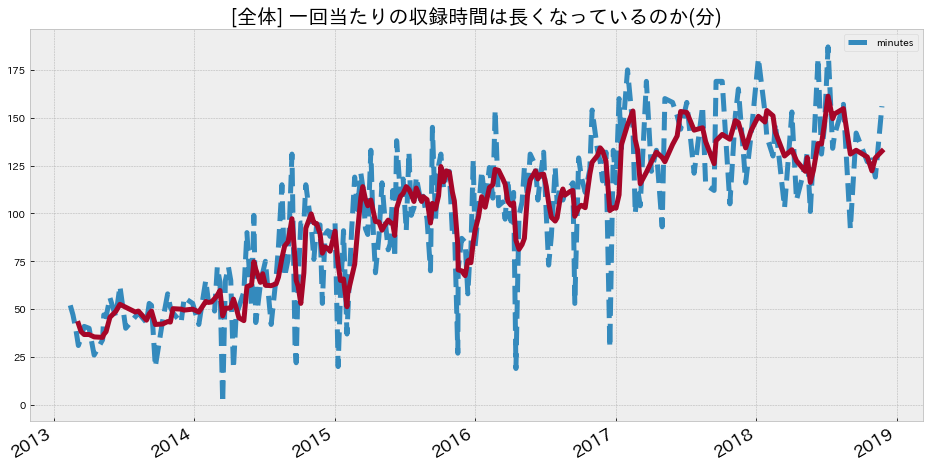

In [109]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
dfm.plot('date', 'minutes', linewidth=5, linestyle='--', ax=ax)
dfm.set_index('date')['minutes'].rolling(window=4).mean().plot(linewidth=5, ax=ax)
ax.set_title('[全体] 一回当たりの収録時間は長くなっているのか(分)', fontsize=20)
ax.tick_params(axis='x', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

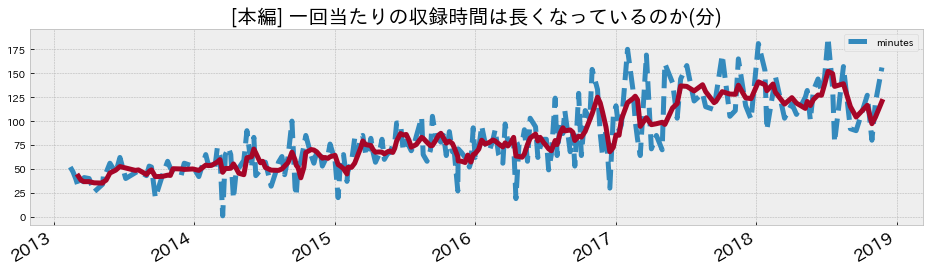

In [153]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
df.query('~is_aftershow').plot('date', 'minutes', linewidth=5, linestyle='--', ax=ax)
df.query('~is_aftershow').set_index('date')['minutes'].rolling(window=4).mean().plot(linewidth=5, ax=ax)
ax.set_title('[本編] 一回当たりの収録時間は長くなっているのか(分)', fontsize=20)
ax.tick_params(axis='x', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

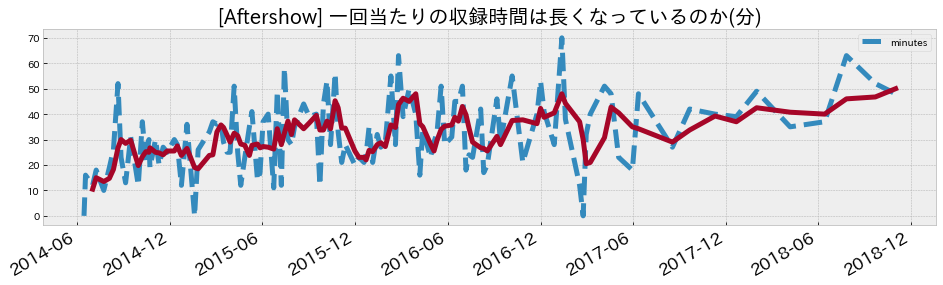

In [154]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
df.query('is_aftershow').plot('date', 'minutes', linewidth=5, linestyle='--', ax=ax)
df.query('is_aftershow').set_index('date')['minutes'].rolling(window=4).mean().plot(linewidth=5, ax=ax)
ax.set_title('[Aftershow] 一回当たりの収録時間は長くなっているのか(分)', fontsize=20)
ax.tick_params(axis='x', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

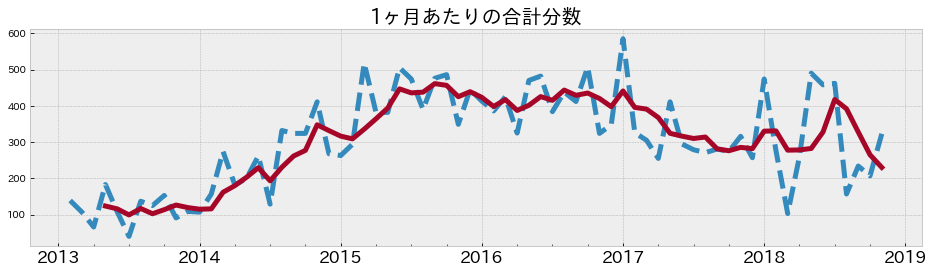

In [156]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax = df.groupby(pd.Grouper(key='date', freq='1M'))['minutes'].sum().plot(linewidth=5, linestyle='--', ax=ax)
ax = df.groupby(pd.Grouper(key='date', freq='1M'))['minutes'].sum().rolling(window=4).mean().plot(linewidth=5, ax=ax)
ax.set_title('1ヶ月あたりの合計分数', fontsize=20)
ax.tick_params(axis='x', labelsize='xx-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

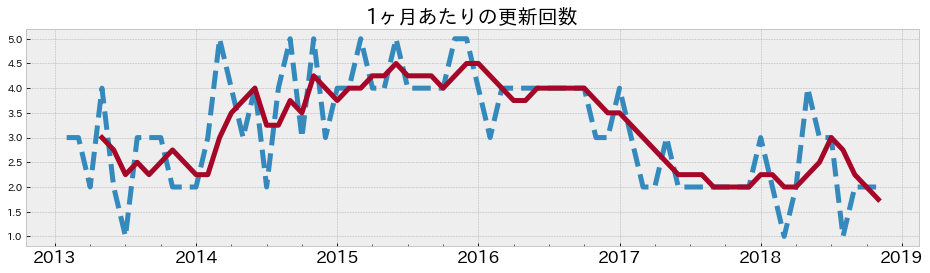

In [157]:
    fig = plt.figure(figsize=(16, 4))
    ax = dfm.groupby(pd.Grouper(key='date', freq='1M')).size().plot(linewidth=5, linestyle='--')
    ax = dfm.groupby(pd.Grouper(key='date', freq='1M')).size().rolling(window=4).mean().plot(linewidth=5, ax=ax)
    ax.set_title('1ヶ月あたりの更新回数', fontsize=20)
    ax.tick_params(axis='x', labelsize='xx-large')
    ax.set_xlabel('')
    ax.set_ylabel('')

In [158]:
persons = []
for i, row in df.query('~is_aftershow').iterrows():
    tmp_persosn = row['persons']
    persons.extend(tmp_persosn)

In [159]:
s_persons = pd.Series(persons)
s_persons = s_persons[s_persons != 'miyagawa']

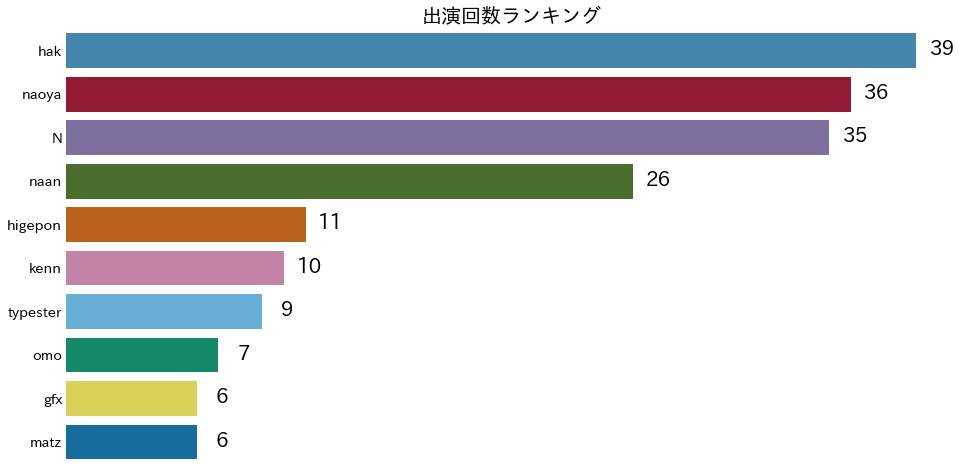

In [161]:
fig = plt.figure(figsize=(16,8))

tmp_df = s_persons.value_counts()[:10].to_frame('value').reset_index().rename(columns={'index': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df)
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.03, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('出演回数ランキング', fontsize=20)
ax.patch.set_facecolor('white') 

ax.patch.set_alpha(0)
plt.grid(False)

In [123]:
shownotes = []
for i, row in df.iterrows():
    tmp_shownote = row['shownotes']
    shownotes.extend(tmp_shownote)
s_shownotes = pd.Series(shownotes)

In [192]:
ignore_word = [':', '/', '-', '–', 'to', 'for', 'the', 'and', '|', 'in', 'of', 'a', 'is', 'on', 'with', 'how', 'new', 'by', '2', 'at', 'rebuild:']

In [193]:
shownotes_split = []
for i, row in df.iterrows():
    tmp_shownote = row['shownotes']
    for t in tmp_shownote:
        tmp_split = t.split()
        shownotes_split.extend(tmp_split)
shownotes_split = [s.lower().replace(',', '') for s in shownotes_split]
shownotes_split = [s for s in shownotes_split if s not in ignore_word]

s_shownotes_split = pd.Series(shownotes_split)

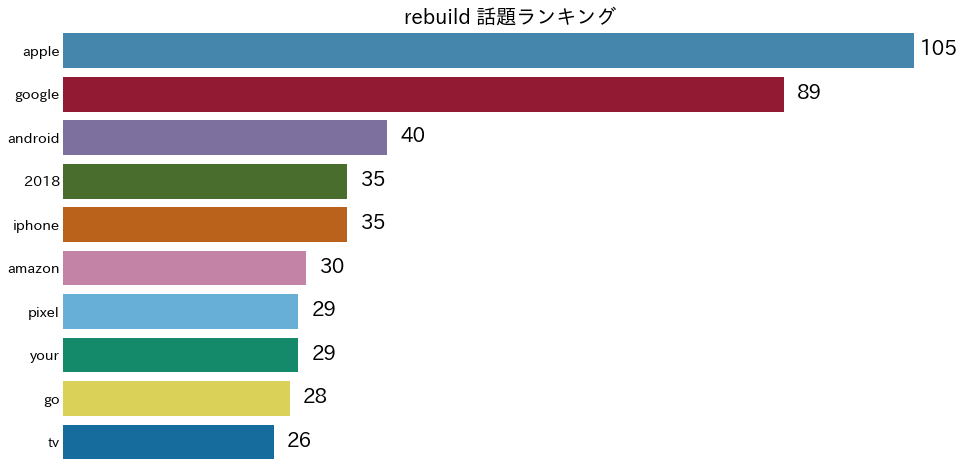

In [195]:
plt.figure(figsize=(16,8))

tmp_df = s_shownotes_split.value_counts()[:10].to_frame('value').reset_index().rename(columns={'index': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df)
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.03, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('rebuild 話題ランキング', fontsize=20)

ax.patch.set_alpha(0)
ax.patch.set_facecolor('white') 
plt.grid(False)

In [127]:
from copy import deepcopy

In [128]:
ls_dfs = []
for i, row in df.iterrows():
    persons = row['persons']
    for p in persons:
        new_row = deepcopy(row)
        new_row['person'] = p
        ls_dfs.append(new_row)

In [129]:
dfs = pd.DataFrame(ls_dfs)

In [175]:
ls_dfms = []
for i, row in dfm.iterrows():
    persons = row['persons']
    for p in persons:
        new_row = deepcopy(row)
        new_row['person'] = p
        ls_dfms.append(new_row)
dfms = pd.DataFrame(ls_dfms)

In [130]:
top10_speaker = s_persons.value_counts()[:10].index.tolist()

Text(0,0.5,'')

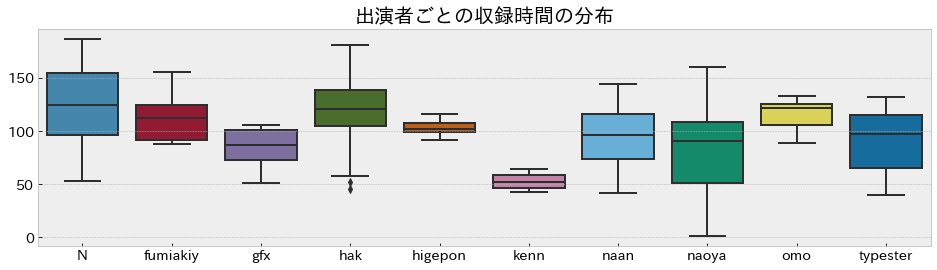

In [176]:
ax = sns.boxplot(data=dfms.query('person in @top10_speaker').sort_values('person'), x='person', y='minutes')
ax.set_title('出演者ごとの収録時間の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

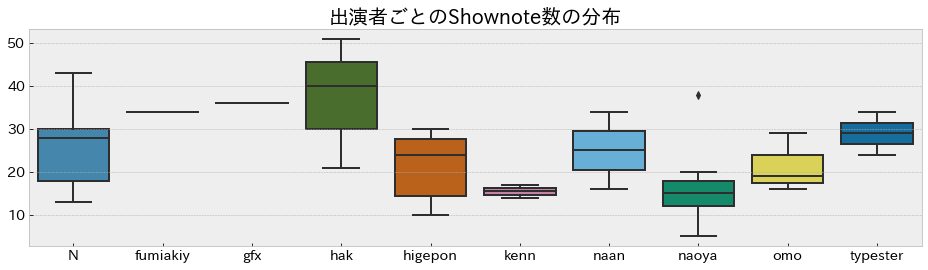

In [183]:
ax = sns.boxplot(data=dfms.query('n_shownotes > 0').query('person in @top10_speaker').sort_values('person'), x='person', y='n_shownotes')
ax.set_title('出演者ごとのShownote数の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

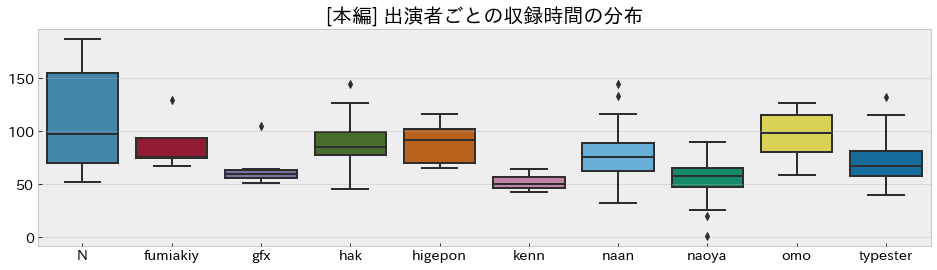

In [178]:
ax = sns.boxplot(data=dfs.query('~is_aftershow').query('person in @top10_speaker').sort_values('person'), x='person', y='minutes')
ax.set_title('[本編] 出演者ごとの収録時間の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

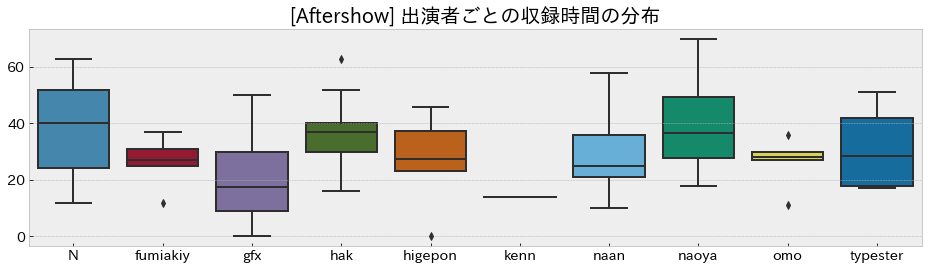

In [179]:
ax = sns.boxplot(data=dfs.query('is_aftershow').query('person in @top10_speaker').sort_values('person'), x='person', y='minutes')
ax.set_title('[Aftershow] 出演者ごとの収録時間の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

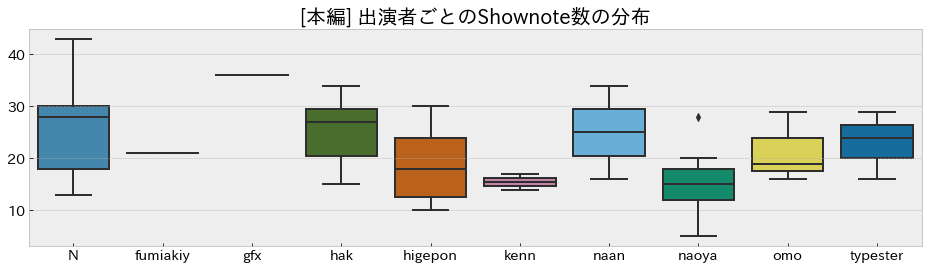

In [180]:
ax = sns.boxplot(data=dfs.query('~is_aftershow').query('n_shownotes > 0').query('person in @top10_speaker').sort_values('person'), x='person', y='n_shownotes')
ax.set_title('[本編] 出演者ごとのShownote数の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

Text(0,0.5,'')

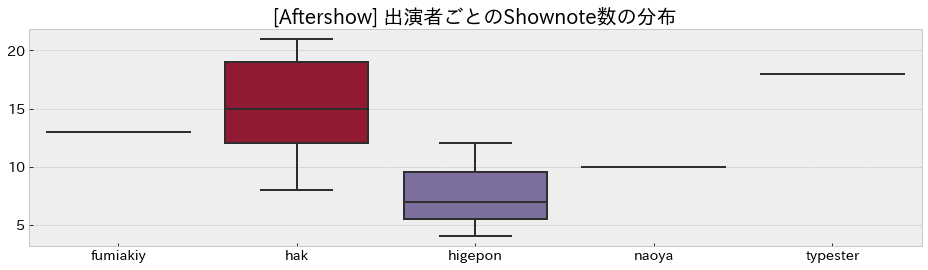

In [182]:
ax = sns.boxplot(data=dfs.query('is_aftershow').query('person in @top10_speaker').query('n_shownotes > 0').sort_values('person'), x='person', y='n_shownotes')
ax.set_title('[Aftershow] 出演者ごとのShownote数の分布', fontsize=20)
ax.tick_params(axis='both', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')

In [141]:
df['minutes'].sum()

21406

In [146]:
21406/60

356.76666666666665

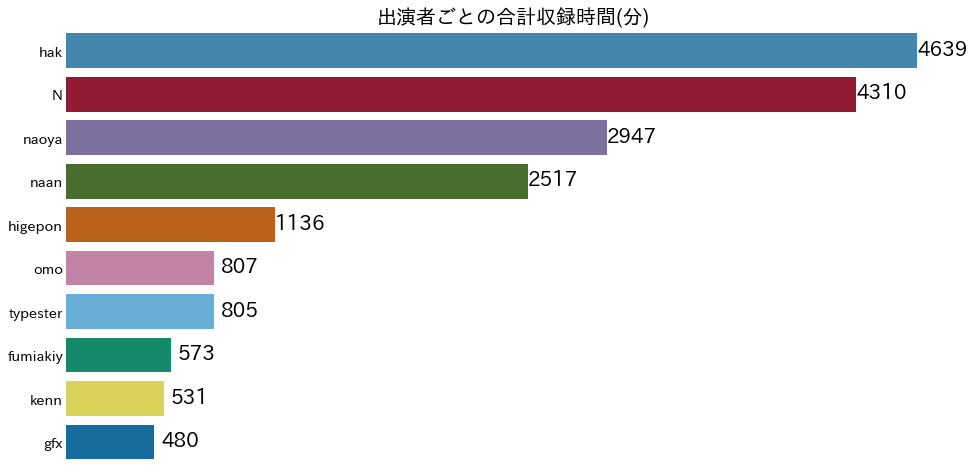

In [143]:
plt.figure(figsize=(16,8))

tmp_df = dfs.groupby('person')['minutes'].sum().sort_values(ascending=False)[1:11].to_frame('value').reset_index().rename(columns={'person': 'name'})
ax = sns.barplot(x='value', y='name', data=tmp_df)
max_ = tmp_df['value'].max()

for i, (_, row) in enumerate(tmp_df.iterrows()):
    text = ax.text(row['value'] + max_*.03, i+0.1, row['value'], color='black', ha="center", fontsize=20)

[spine.set_visible(False) for spine in ax.spines.values()]
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.tick_params(axis='y', labelsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('出演者ごとの合計収録時間(分)', fontsize=20)

ax.patch.set_alpha(0)
plt.grid(False)

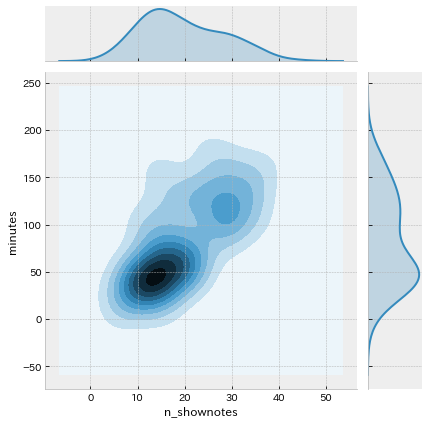

In [144]:
sns.jointplot("n_shownotes", "minutes", data=df.query('n_shownotes > 0'), kind="kde")

In [196]:
from wordcloud import WordCloud

[None, None, None, None]

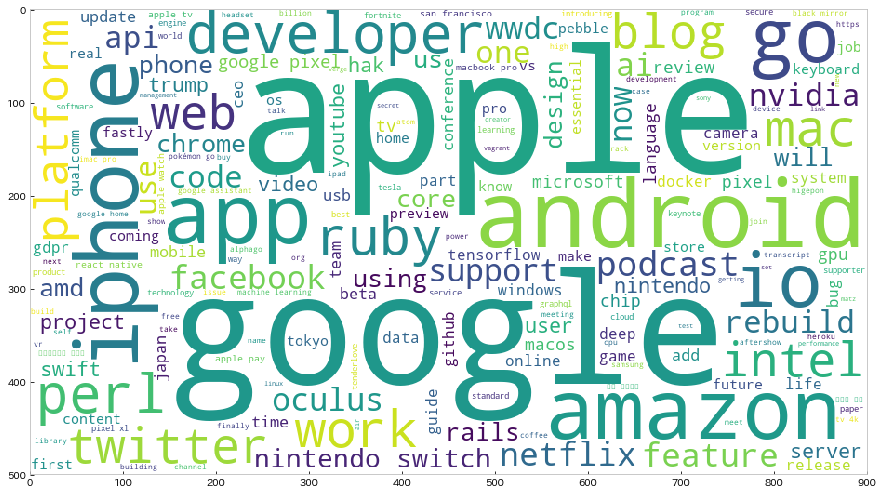

In [202]:
plt.figure(figsize=(15,12))
wordcloud = WordCloud(background_color="white", width=900, height=500).generate(" ".join(shownotes_split))
plt.imshow(wordcloud)
plt.grid(False)
ax.tick_params(bottom=False, left=False, labelbottom=False)
ax.set_xlabel('')
ax.set_ylabel('')
[spine.set_visible(False) for spine in ax.spines.values()]

In [203]:
dfm.sort_values('minutes', ascending=False)

,date_main,persons_main,record_time_main,shownotes_main,title_main,n_shownotes_main,minutes_main,is_aftershow_main,show_no,date_after,...,record_time_after,shownotes_after,title_after,n_shownotes_after,minutes_after,is_aftershow_after,date,minutes,persons,n_shownotes
211,2018-07-06,"[N, miyagawa]",3:07:16,"[YouTube TV, Hulu Live TV, Los Gatos Californi...",213: Open-Plan Jail (N),24,187,False,213,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-06,187.0,"[N, miyagawa]",24.0
196,2018-01-06,"[drikin, miyagawa]",3:01:13,"[Koh Aoki - YouTube, Strict-Transport-Security...",198: Gaming Hogehoge (drikin),25,181,False,198,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-06,181.0,"[drikin, miyagawa]",25.0
208,2018-06-10,"[hak, miyagawa]",2:24:36,"[Apple Events - WWDC Keynote, June 2018, iOS 1...",210: The VR Era (hak),27,144,False,210,2018-06-14,...,37:21,"[ダンジョンメーカー, Indie Game Fest, NieR: Automata, H...",Aftershow 210: Don't Install This Game (hak),13.0,37.0,True,2018-06-10,181.0,"[hak, miyagawa]",40.0
171,2017-01-31,"[N, miyagawa]",2:55:51,[Apple releases Find My AirPods in iOS 10.3 be...,"173: There Are No Gems, Only Stones (N)",43,175,False,173,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-31,175.0,"[N, miyagawa]",43.0
176,2017-03-21,"[N, miyagawa]",2:49:39,"[ゼルダの伝説 ブレス オブ ザ ワイルド | Nintendo, リングにかけろ, THE...",178: Professionals of Cargo Culting (N),30,169,False,178,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-21,169.0,"[N, miyagawa]",30.0
189,2017-09-18,"[hak, miyagawa]",2:07:03,"[東京マラソン2018, Jeff Williams, Apple Watch Series...",191: Two More Bowls of Rice (hak),29,127,False,191,2017-09-21,...,42:32,"[Webpass - Gigabit & High-Speed Internet, Uber...",Aftershow 191: Alternative Momoi (hak),12.0,42.0,True,2017-09-18,169.0,"[hak, miyagawa]",41.0
190,2017-10-04,"[N, miyagawa]",2:49:02,"[Google Pixel 2 event: what to expect, iPhone ...",192: The Future Is Now (N),37,169,False,192,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-04,169.0,"[N, miyagawa]",37.0
193,2017-11-15,"[N, miyagawa]",2:45:02,[House of Cards writers to rework season 6 wit...,195: Notch By Perfume (N),28,165,False,195,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-15,165.0,"[N, miyagawa]",28.0
180,2017-05-08,"[N, miyagawa]",2:40:14,[Macron beats Le Pen in French presidential el...,"182: Garbage In, Poo Out (N)",16,160,False,182,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-08,160.0,"[N, miyagawa]",16.0
169,2017-01-09,"[naoya, miyagawa]",1:30:59,[],171: Psychologically Safe Podcast (naoya),0,90,False,171,2017-01-12,...,1:10:21,[],Aftershow 171: Muscle Memory (naoya),0.0,70.0,True,2017-01-09,160.0,"[naoya, miyagawa]",0.0
